# **Midiendo la Volatilidad**

In [238]:
import pandas as pd
import numpy as np

import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.expected_returns import mean_historical_return

sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [239]:
tickers = ["^GSPC", "BTC-USD"]
end = dt.datetime.now()
start = end - dt.timedelta(days = 365)

df_raw = yf.download(tickers= tickers, start = start, end= end)

# Reseteamos los índices del dataframe
df_raw.index = df_raw.index.strftime('%Y-%m-%d')
df_raw = df_raw.dropna()
df_raw = df_raw.rename(columns= {"^GSPC": "SP500"})

data = df_raw["Close"]
data.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,BTC-USD,SP500
Date,,
2025-01-03,98107.429688,5942.470215
2025-01-06,102078.085938,5975.379883
2025-01-07,96922.703125,5909.029785
2025-01-08,95043.523438,5918.250000
2025-01-10,93948.945312,5845.279785


## **Retornos**

### Hay varias formas de calcular retornos, en este caso hablaremos de las siguientes dos:

### **1. Retorno Simple**

$$
\LARGE
r_t = \frac {P_t + D_t - P_{t-1}}{P_{t-1}} = \frac {P_t + D_t}{P_{t-1}} - 1~
$$

### **2. Retorno Logarítmico o Geométrico**

$$
\Large
R_t = ln\left[\frac{P_t + D_t}{P_{t-1}}\right]
$$

### Comentario: usualmente se presupone que el dividendo es cero. Si bien es cierto que en el **Modelo de Valoración de Dividendos** toma especial importancia el dividendo para establecer el **valor intrínseco**, al inversionista medio solo le interesa el incremento en capital o cotización del activo, no los flujos que pueda generar. Teniendo esto claro asumimos que los dividendos son 0.

### Calculamos retornos:

In [240]:
log_returns = pd.DataFrame()

for ticker in data:
    log_returns[ticker]= np.log(data[ticker] / data[ticker].shift(1)).dropna()

log_returns

,BTC-USD,SP500
Date,,
2024-01-12,-0.078843,0.000751
2024-01-16,0.007017,-0.003738
2024-01-17,-0.009600,-0.005633
2024-01-18,-0.035254,0.008767
2024-01-19,0.008599,0.012238
...,...,...
2025-01-03,0.012519,0.012517
2025-01-06,0.039675,0.005523
2025-01-07,-0.051824,-0.011166


[]

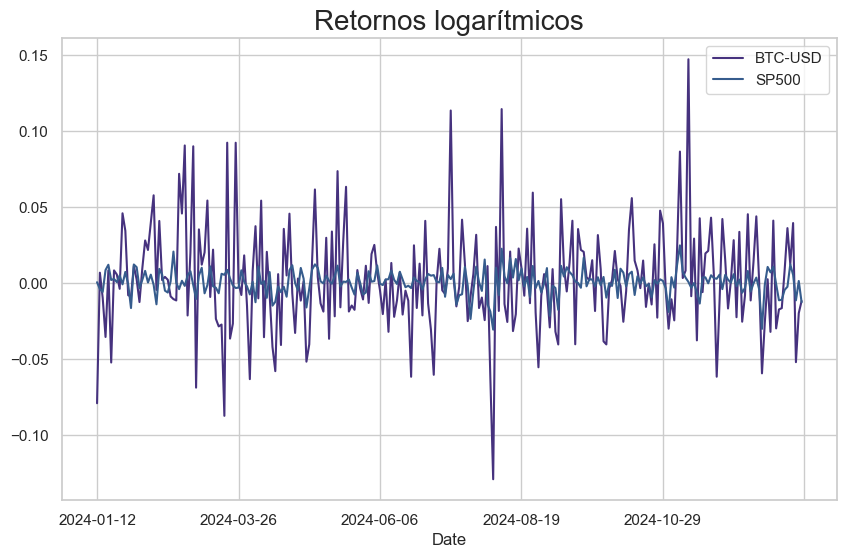

In [241]:
log_returns.plot()
plt.title("Retornos logarítmicos", fontsize= 20)
plt.ylabel("")
plt.gcf().set_size_inches(10, 6)
plt.plot()

### Su distribución:

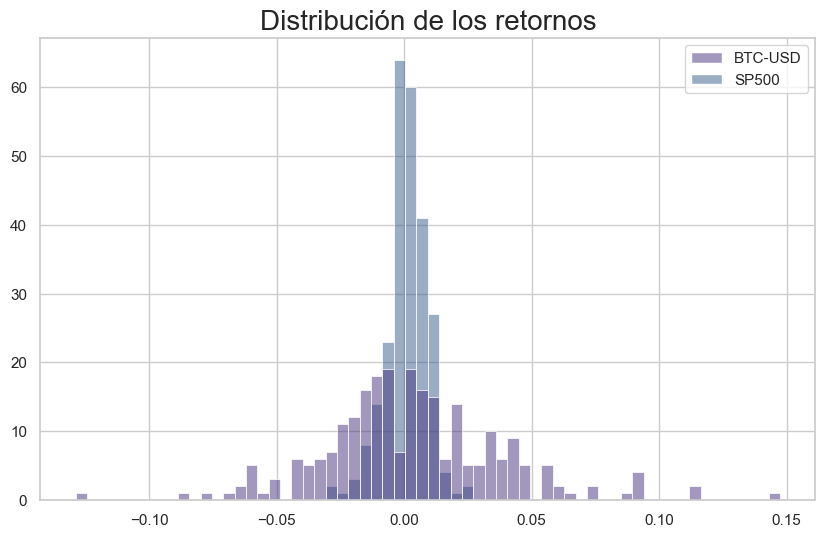

In [242]:
sns.histplot(data = log_returns)
plt.title("Distribución de los retornos", fontsize = 20)
plt.ylabel("")
plt.gcf().set_size_inches(10, 6)

## **Anualizar la rentabilidad**

### Para anualizar una tasa de retorno diario se usa la siguiente fórmula para el caso de rendimientos logarítmicos:

$$
\LARGE
\text{Tasa anualizada (log)} = Log\, r \cdot \text{días de negociación}

In [243]:
daily_returns = log_returns.mean()

for ticker in daily_returns.index:
    daily_return = daily_returns[ticker]
    print(f"El retorno promedio diario de {ticker}: {daily_return:.2%}")

print("=" * 50)

expected_returns = mean_historical_return(log_returns,
                                           returns_data= True,
                                           frequency = 252,
                                            log_returns= True)
for ticker in expected_returns.index:
    exp_return = expected_returns[ticker]
    print(f"El retorno histórico anual de {ticker}: {exp_return:.2%}")

El retorno promedio diario de BTC-USD: 0.28%
El retorno promedio diario de SP500: 0.08%
El retorno histórico anual de BTC-USD: 74.67%
El retorno histórico anual de SP500: 21.47%


## **Anualizar la Volatilidad**

### Para anualizar la volatilidad se usa la raiz cuadrada del tiempo:

$$
\LARGE
\sigma^2_{T días} = \sum_{t=1}^T \sigma_t{^2}
$$

$$
\LARGE
\sigma_{T días}^2 =  T\cdot\sigma_{día \, 1}^2 
$$

$$
\LARGE
\sigma_{T días} = \sigma_{día 1} \cdot \sqrt{T}
$$

In [244]:
def volatility_rolling(returns: pd.DataFrame, window: int)-> pd.DataFrame:
    vol_rolling = returns.rolling(window).std()
    return vol_rolling

vol_rolling = volatility_rolling(log_returns, 20).dropna()


Volatilidad diaria de BTC-USD: 3.52%
Volatilidad diaria de SP500: 0.80%
La volatilidad histórica de BTC-USD: 55.80%
La volatilidad histórica de SP500: 12.77%


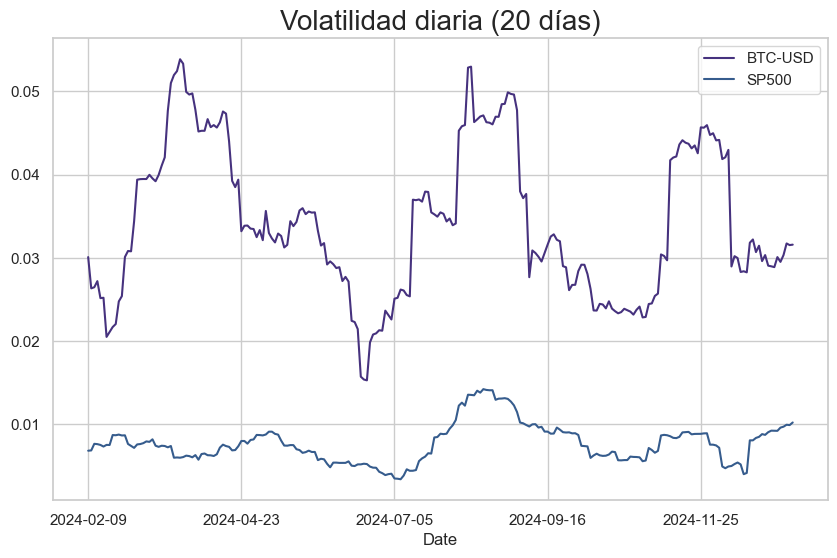

0.12773629640369186


In [245]:
daily_volatility = log_returns.std()
annual_volatilities = daily_volatility * np.sqrt(252)

for ticker in daily_volatility.index: 
    volatility = daily_volatility[ticker]
    print(f"Volatilidad diaria de {ticker}: {volatility:.2%}")

print("=" * 50)

for ticker in annual_volatilities.index:
    exp_vol = annual_volatilities[ticker]
    print(f"La volatilidad histórica de {ticker}: {exp_vol:.2%}")

vol_rolling.plot()
plt.title("Volatilidad diaria (20 días)", fontsize = 20)
plt.gcf().set_size_inches(10, 6)
plt.show()
print(exp_vol)


In [246]:
daily_volatility * np.sqrt(252)

BTC-USD    0.558011
SP500      0.127736
dtype: float64

## **Otras medidas de medición de Volatilidad**

## **1. Modelo de Parkinson**

$$
\LARGE
\sigma = \sqrt{\frac{1}{4\cdot n \cdot ln\,2} \sum_{t=1}^n \left[ \left(ln \frac{H_t}{L_t}\right)\right]^2}
$$


In [247]:
def parkinson_volatility(data: pd.DataFrame):

    high = data["High"]
    low = data["Low"]

    # Miramos el horizonte temporal
    n = len(high)
    # Prueba lógica
    if n == 0:
        return np.nan
    # Calculamos la diferencia intradía
    log_diff = np.log(high / low)
    # Hallamos la volatilidad de Parkinson
    park_vol = np.sqrt((1 / (4 * n * np.log(2))) * np.sum(log_diff ** 2))
    # Devolvemos
    return park_vol

In [248]:
def parkinson_volatility_rolling(data: pd.DataFrame, window: int) -> pd.DataFrame:

    high = data["High"]
    low = data["Low"]
     # Calculamos la diferencia logarítmica intradía
    log_diff = np.log(high / low)
    
    # Aplicamos la fórmula de Parkinson con una ventana móvil
    park_vol_rolling = log_diff.rolling(window).apply(lambda x: np.sqrt((1 / (4 * window * np.log(2))) * np.sum(x**2)), raw=True)
    
    return park_vol_rolling

Volatilidad diaria de Parkinson para BTC-USD: 3.15%
Volatilidad diaria de Parkinson para SP500: 0.62%
Volatilidad anual de Parkinson para BTC-USD: 49.95%
Volatilidad anual de Parkinson para SP500: 9.85%


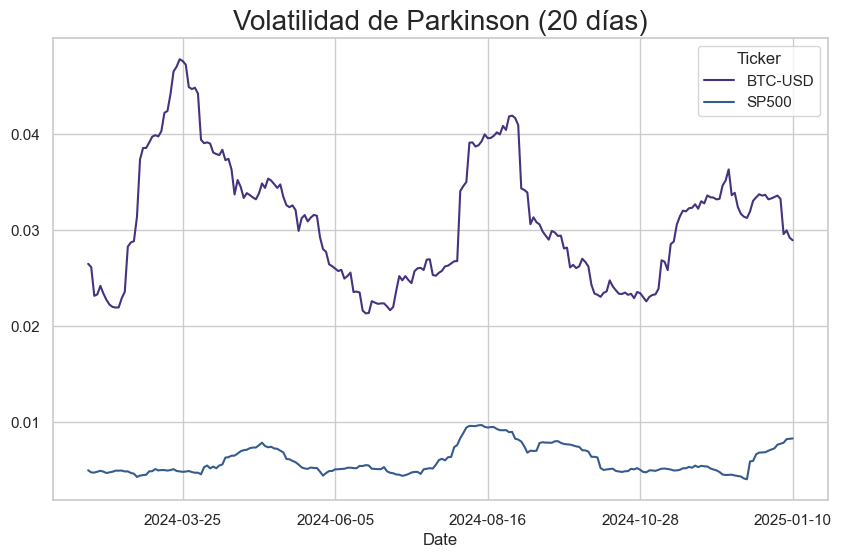

In [249]:
data2 = df_raw.copy()
parkinson_volatilities = parkinson_volatility(data2)

annual_volatility_park = parkinson_volatilities * np.sqrt(252)

for ticker in parkinson_volatilities.index: 
    park_vol = parkinson_volatilities[ticker]
    print(f"Volatilidad diaria de Parkinson para {ticker}: {park_vol:.2%}")

print("=" * 60)

for ticker in annual_volatility_park.index: 
    annual_park_vol = annual_volatility_park[ticker]
    print(f"Volatilidad anual de Parkinson para {ticker}: {annual_park_vol:.2%}")


parkinson_volatilities_rolling = parkinson_volatility_rolling(data = data2,
                                                              window= 20)
parkinson_volatilities_rolling.plot()
plt.title("Volatilidad de Parkinson (20 días)", fontsize= 20)
plt.gcf().set_size_inches(10, 6)

## **2. Volatilidad de Garman-Klass**

$$
\LARGE
\sigma_{\text{GK}} = \sqrt{\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left[ln \frac{h_i}{l_i} \right]^2 -\frac{1}{n} \sum_{i=1}^n [2\cdot ln 2 - 1 ] \left[ln\frac{c_i}{o_i}\right]^2 }
$$

In [250]:
def Garman_klass(data: pd.DataFrame) -> pd.Series:

    # Creamos varibales (de yfinance)
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    open = data["Open"]

    # Número de periodos
    n = len(data)

    # Logaritmos de las variables
    log_h_l_diff = np.log(high/low)
    log_c_o_diff = np.log(close/open)

    # Calcular el Garman-Klass
    gk = np.sqrt((1/n) * np.sum((1/2) * log_h_l_diff**2) - (1/n) * np.sum((2*np.log(2)-1) * log_c_o_diff**2))
    return gk

In [251]:
def Garman_klass_rolling(data: pd.DataFrame, window: int):

    # Creamos varibales (de yfinance)
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    open = data["Open"]

    # Número de periodos
    n = len(data)

    # Logaritmos de las variables
    log_h_l_diff = np.log(high/low)
    log_c_o_diff = np.log(close/open)

    # Calcular el Garman-Klass
    gk_rolling = np.sqrt(
          (1 / window) * 
          (0.5 * log_h_l_diff.rolling(window=window).sum()**2 - 
           (2 * np.log(2) - 1) * log_c_o_diff.rolling(window=window).sum()**2)).dropna()
    return gk_rolling

Volatilidad diaria de Garman-Klass para BTC-USD: 3.16%
Volatilidad diaria de Garman-Klass para SP500: 0.62%
Volatilidad anual de Garman-Klass para BTC-USD: 50.16%
Volatilidad anual de Garman-Klass para SP500: 9.86%


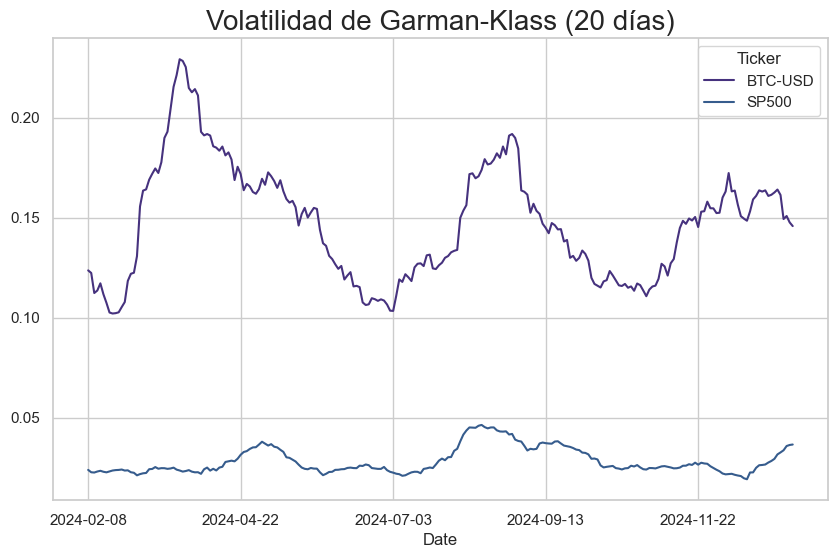

In [252]:
gk = Garman_klass(data = data2)


annual_volatility_gk = gk * np.sqrt(252)

for ticker in gk.index:
    gk_volatilities = gk[ticker]
    print(f"Volatilidad diaria de Garman-Klass para {ticker}: {gk_volatilities:.2%}")

print("=" * 60)

for ticker in annual_volatility_gk.index: 
    annual_gk_vol = annual_volatility_gk[ticker]
    print(f"Volatilidad anual de Garman-Klass para {ticker}: {annual_gk_vol:.2%}")

gks_rolling = Garman_klass_rolling(data2, window= 20)
gks_rolling.plot()
plt.title("Volatilidad de Garman-Klass (20 días)", fontsize= 20)
plt.gcf().set_size_inches(10, 6)

### **Referencia:**

### Castellanos Hernán, E. (2011). Opciones y futuros de renta variable: Manual práctico. Madrid: Instituto BME